# Label-noise robust logistic regression

The class labels in the training data are commonly assumed to be perfectly accurate. This is not always a justified assumption. Annotators may have made mistakes for example, because the assignment is not obvious or because the annotator is not an expert on the task.

It is possible to reduce the impact of labeling mistakes by changing the assumptions the classifier makes. This notebook explores one way to extend a multiclass logistic regression classifier to account for class-dependent label noise. The robust regression model is evaluated on the iris dataset with added artificial label noise.

This is inspired by the [Label-Noise Robust Logistic Regression and Its Applications](https://www.cs.bham.ac.uk/~axk/ecml2012.pdf) paper by Bootkrajang and Kabán (ECML PKDD 2012).

In [1]:
%matplotlib inline

import random
import pystan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
sns.set(style='white', font_scale=1.2)

## Data

Let's evaluate robust regression model on the well know iris data set. The data consists of measurements of physical properties (the features) of three iris subspecies (the classes).

In [3]:
iris = load_iris()

species = pd.Series(iris['target']).map(lambda x: iris['target_names'][x]).rename('Species')
features = pd.DataFrame(iris['data'],columns=iris['feature_names'])
features.join(species).sample(frac=1).head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
20,5.4,3.4,1.7,0.2,setosa
106,4.9,2.5,4.5,1.7,virginica
53,5.5,2.3,4.0,1.3,versicolor
142,5.8,2.7,5.1,1.9,virginica
36,5.5,3.5,1.3,0.2,setosa


The data is split randomly into 120 train and 30 test samples, keeping the class proportions in train and test sets. The features are normalized to zero mean and unit variance.

In [4]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(iris['data']),
                       columns=iris['feature_names'])
y = iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'Train samples: {len(y_train)}')
print(f'Test samples: {len(y_test)}')

print(f'Feature dimensionality: {X_train.shape[1]}')
print(f'Class proportions: {iris["target_names"][0]}: {(y_train == 0).mean():.2f}, {iris["target_names"][1]}: {(y_train == 1).mean():.2f}, {iris["target_names"][2]}: {(y_train == 2).mean():.2f}')

Train samples: 120
Test samples: 30
Feature dimensionality: 4
Class proportions: setosa: 0.33, versicolor: 0.33, virginica: 0.33


## Standard logistic regression

The text book logistic regression model assumes that the observed label $y$ has been generated by a categorical logit distribution.

![logistic regression plate notation](images/logistic.png)

\begin{equation*}
y \sim \text{categorical}(\text{softmax}(\alpha + \beta^T X))
\end{equation*}

We'll apply weak L2 regularization on the intercept $\alpha$ and weights $\beta$ (the C parameter on the scikit-learn class in the code below).

The following code block trains a logistic regression on one of the train/test folds.

In [5]:
logreg = LogisticRegression(C=10)
logreg.fit(X_train, y_train)
ypred_train = logreg.predict(X_train)
ypred_test = logreg.predict(X_test)

print(f'intercept = {logreg.intercept_}')
print(f'beta = {logreg.coef_}')

print()
print('Train')
print(classification_report(y_train, ypred_train, target_names=iris['target_names']))

print()
print('Test')
print(classification_report(y_test, ypred_test, target_names=iris['target_names']))

intercept = [-0.01301264  3.81748921 -3.80447657]
beta = [[-1.78906204  1.67948409 -3.31162925 -3.17963852]
 [ 1.12921349 -0.28570565 -1.15090254 -1.43615124]
 [ 0.65984855 -1.39377845  4.46253179  4.61578976]]

Train
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.95      0.96        40
   virginica       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120


Test
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Robust logistic regression

The robust logistic regression variant proposed by Bootkrajang and Kabán assumes that the observed labels are corrupted versions of the true labels. The true labels are latent variables generated by the standard logistic regression model. The latent labels are then corrupted by flipping a label to another with a class-dependent probability.

The flip probability $p(y = j | z = i)$ is denoted by $\gamma_{ij}$ below. The flip probabilities are parameters to be estimated during the training. They can be asymmetric, that is, the probability for switching from A to B doesn't have to equal to the B-to-A probability.

![robust regression plate notation](images/robust.png)

\begin{align*}
z &\sim \text{categorical}(\text{softmax}(\alpha + \beta^T X))\\
y &\sim \text{categorical}(\gamma_{z \cdot})
\end{align*}

By combining the classifier and the noise model into a single unified model, it is possible to learn them jointly. This should lead to more accurate estimates than any process that fits a classifier and identifies noisy samples in separate steps.

The following defines and compiles the robust regression as a Stan model. A probabilistic programming language such as Stan allows us to define probabilistic models flexibly and derives necessary update equations automatically.

The latent label $z$ is marginalized out by summing over feasible values. We apply the same L2 regularization as before on the regression weights $\alpha$ and $\beta$ and a Dirichlet prior on the flip probabilities $\gamma$.

In [6]:
robust_code = """
data {
    int<lower=0> N;  // number of observations
    int<lower=1> D;  // number of predictors
    int<lower=2> K;  // number of classes
    matrix[N, D] X;
    int<lower=1,upper=K> y[N];  // observed (noisy) class labels
    real prior_sigma;
    real transition_prior;
}
parameters {
    vector[K] alpha;
    matrix[D, K] beta;
    simplex[K] gamma[K];
}
model {
    matrix[N, K] x_beta = rep_matrix(to_row_vector(alpha), N) + X * beta;
    
    alpha ~ normal(0, prior_sigma);
    to_vector(beta) ~ normal(0, prior_sigma);
    for (i in 1:K) {
        gamma[i] ~ dirichlet(rep_vector(transition_prior, K));
    }

    for (n in 1:N) {
        vector[K] u = rep_vector(0.0, K);
        vector[K] w = softmax(x_beta[n]');
        
        for (j in 1:K) {
            u += w[j] * gamma[j];
        }
                
        y[n] ~ categorical(u);
    }
}
"""

robust_model = pystan.StanModel(model_code=robust_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_811ef81dc39844af59dc6dadfede0a89 NOW.


This defines a class that adapts a Stan model into a scikit-learn-like interface. A uniform interface simplifies comparison against scikit-learn-provided classifiers. The fit function finds the maximum a posteriori (MAP) estimate for the parameters.

In [7]:
def robust_regression_param_initializer(num_classes, num_features):
    def wrapped():
        return {
            'alpha': np.random.uniform(-2, 2, num_classes),
            'beta': np.random.uniform(-2, 2, (num_features, num_classes)),
            'gamma': stochastic_identity(num_classes)
        }

    return wrapped

def stochastic_identity(size, diag_value=0.99):
    X = (1-diag_value)/(size-1)*np.ones((size, size))
    np.fill_diagonal(X, diag_value)
    return X

class StanMAPClassifierAdapter():
    def __init__(self, stan_model, prior_sigma=1, transition_prior=1, restarts=1):
        """An adapter that provides a scikit-learn-like interface to fitting a Stan model.
        
        stan_model is a compiled Stan model.
        prior_sigma is the weight vector prior variance.
        transition_prior is the value of the dirichlet prior for the transtion matrix.
        restarts is the number of optimization restarts.
        """
        
        self.sm = stan_model
        self.intercept_ = None
        self.coef_ = None
        self.gamma_ = None
        self.prior_sigma = prior_sigma
        self.transition_prior = transition_prior
        self.restarts = restarts

    def fit(self, X, y):
        """Finds the MAP estimate for the parameters."""
        
        K = len(np.unique(y))
        data = {
            'N': X.shape[0],
            'D': X.shape[1],
            'K': K,
            'X': X,
            'y': y + 1,
            'prior_sigma': self.prior_sigma,
            'transition_prior': self.transition_prior
        }
        
        best_par = None
        best_lp = None
        for _ in range(max(self.restarts, 1)):
            init = robust_regression_param_initializer(K, X.shape[1])
            res = self.sm.optimizing(data=data, init=init, as_vector=False)
            if best_lp is None or res['value'] > best_lp:
                best_par = res['par']
                best_lp = res['value']
            
        self.intercept_ = best_par['alpha']
        self.coef_ = best_par['beta'].T
        self.gamma_ = best_par['gamma']

    def predict(self, X):
        return np.asarray((self.intercept_ + X.dot(self.coef_.T)).idxmax(axis=1))

Let's train the robust model on the same data as before (no added noise, yet). The prediction results and the parameter values match quite closely to the results of the scikit-learn LogisticRegression above. This gives us confidence that the Stan model is implemented correctly because it should find the same solution as the textbook logistic regression (assuming that there are no incorrect labels in the iris dataset!).

In [8]:
clf = StanMAPClassifierAdapter(robust_model, prior_sigma=10, transition_prior=2, restarts=6)
clf.fit(X_train, y_train)

ypred_train = clf.predict(X_train)
ypred_test = clf.predict(X_test)

print(f'intercept = {clf.intercept_}')
print(f'beta = {clf.coef_}')
print(f'gamma = {clf.gamma_}')

print()
print('Train')
print(classification_report(y_train, ypred_train, target_names=iris['target_names']))

print()
print('Test')
print(classification_report(y_test, ypred_test, target_names=iris['target_names']))

intercept = [ 0.09623955  5.92431511 -6.01685153]
beta = [[-2.50482125  2.34225728 -4.99776859 -4.94005406]
 [ 1.74680805 -0.28204708 -2.33787897 -1.74497602]
 [ 0.76359213 -2.06232716  7.33439937  6.68562472]]
gamma = [[0.9534646  0.02328258 0.02325282]
 [0.02330354 0.95135914 0.02533733]
 [0.02323453 0.02622761 0.95053786]]

Train
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.97      0.97        40
   virginica       0.97      0.97      0.97        40

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120


Test
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   mac

## Posterior sampling

Stan can also sample parameters from the model posterior. This model is non-identifiable, which makes sampling very challenging in this case. Posterior sampling is not pursued further here.

In [9]:
class StanSamplingClassifierAdapter():
    def __init__(self, stan_model, prior_sigma=1, transition_prior=1, n_warmup=1000, n_samples=100, n_chains=4):
        """An adapter that provides a scikit-learn-like interface to fitting a Stan model.
        
        stan_model is a compiled Stan model.
        prior_sigma is the weight vector prior variance.
        transition_prior is the value of the dirichlet prior for the transtion matrix.
        n_warmup is the number of warmup iterations
        n_samples is the number of posterior samples to take
        """
        
        self.sm = stan_model
        self.fitted_model = None
        self.prior_sigma = prior_sigma
        self.transition_prior = transition_prior
        self.n_warmup = n_warmup
        self.n_samples = n_samples
        self.n_chains = n_chains

    def fit(self, X, y):
        """Draw posterior samples from the model."""
        
        K = len(np.unique(y))
        data = {
            'N': X.shape[0],
            'D': X.shape[1],
            'K': K,
            'X': X,
            'y': y + 1,
            'prior_sigma': self.prior_sigma,
            'transition_prior': self.transition_prior
        }
        
        self.fitted_model = self.sm.sampling(data=data, init=robust_regression_param_initializer(K, X.shape[1]),
                                             chains=self.n_chains, warmup=self.n_warmup,
                                             iter=self.n_warmup + self.n_samples)
        
    def predict_samples(self, X):
        samples = self.fitted_model.extract(pars=['alpha', 'beta'])
        alpha = samples['alpha'][:, :, np.newaxis].repeat(X.shape[0], axis=2)
        beta = samples['beta'].swapaxes(1, 2)
        return (alpha + beta.dot(X.T)).argmax(axis=1)

    def predict(self, X):
        samples = self.predict_samples(X)
        return mode(samples, axis=0).mode[0]

In [10]:
clf = StanSamplingClassifierAdapter(robust_model, prior_sigma=10, transition_prior=1, n_warmup=200, n_samples=100, n_chains=1)
clf.fit(X_train, y_train)

ypred_train = clf.predict(X_train)
ypred_test = clf.predict(X_test)

print()
print('Train')
print(classification_report(y_train, ypred_train, target_names=iris['target_names']))

print()
print('Test')
print(classification_report(y_test, ypred_test, target_names=iris['target_names']))


Train
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        40
  versicolor       0.97      0.95      0.96        40
   virginica       0.95      0.97      0.96        40

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120


Test
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



## Evaluation on simulated data

We validate the impact of the robustness modeling on simulated data. The robust and standard logistic regression models are compared on different levels of artificially injected label noise. A fixed proportion of class labels is flipped (asymmetrically) to one of the another classes with a probability that depends on the original class. This noise generation process matches exactly the noise assumption of the robust regression model, and therefore this evaluation favors the robust model compared to real life applications with more complicated noise distribution.

In real applications, acquiring a test set with clean labels can be a considerable challenge, because the same noise process that has corrupted the training dataset is likely to affect the test set, too. However, a test set with clean labels is necessary for fair evaluation of generalization performance. With artificially injected noise we don't have such challenges. Noise is only inject on the training labels and the trained model is evaluated on noise-free test data.

In [11]:
def draw_transition_prob(size):
    U = np.zeros([size, size])
    for i in range(size):
        ind = [x for x in range(size) if x != i]
        U[i, ind] = np.random.dirichlet(0.5*np.ones(size - 1))
    return U

def draw_noisy_labels(y_true, noise_prob, transition_prob):
    K = transition_prob.shape[0]
    N = len(y_true)

    y_noisy = np.array(y_true)
    for i in np.random.choice(N, size=int(noise_prob*N), replace=False):
        y_noisy[i] = np.random.choice(range(K), p=transition_prob[y_true[i], :])

    return y_noisy

def eval_test_error(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    ypred = clf.predict(X_test)
    return 1 - accuracy_score(y_test, ypred)

In [12]:
n_repeats = 30
noise_proportions = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5])

errors = []
for i, flip_prob in enumerate(noise_proportions):
    for _ in range(n_repeats):
        T = draw_transition_prob(3)
        y_noisy = draw_noisy_labels(y_train, flip_prob, T)
        noise_level = 1.0 - (y_noisy == y_train).mean()

        robust_map = StanMAPClassifierAdapter(robust_model, prior_sigma=10, transition_prior=1, restarts=6)
        r_err = eval_test_error(robust_map, X_train, y_noisy, X_test, y_test)
        errors.append({
            'Model': 'Robust regression',
            'Noise level (%)': 100*noise_level,
            'Test error (%)': 100*r_err
        })

        logreg = LogisticRegression(C=10)
        r_err = eval_test_error(logreg, X_train, y_noisy, X_test, y_test)
        errors.append({
            'Model': 'Logistic regression',
            'Noise level (%)': 100*noise_level,
            'Test error (%)': 100*r_err
        })

errors = pd.DataFrame(errors)

The following plot displays the accuracy of the two models on the test set at different noise levels. The shaded region is the standard deviation due to different draws of noise matrix (but excluding posterior uncertainty because the model is learned as a point estimate).

The robust model performs better than the logistic regression on all noise levels. Even when 30% of labels are changed to be incorrect, the robust classifier attains a test error around 10%, while the error of the logistic regression model is roughly doubled.

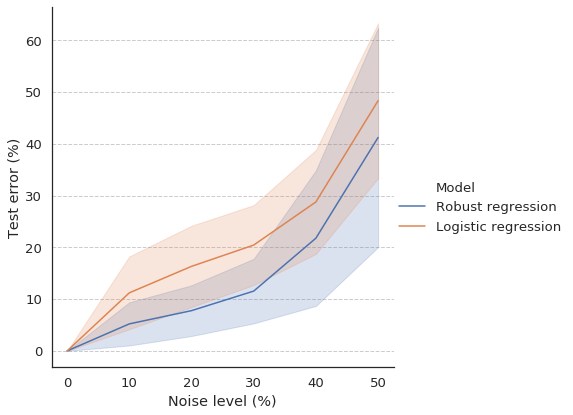

In [13]:
g = sns.relplot(x='Noise level (%)', y='Test error (%)', hue='Model', kind='line', data=errors, height=6, ci="sd")
g.ax.grid(axis='y', linestyle='--')